# Машинное обучение в биологии

### Семинар 4: Методы понижения размерности

#### Визуализация транскриптомных данных. Анализ данных, выявление выбросов и батч-эффекта.

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import sklearn.datasets
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE

from sklearn.metrics import  mean_absolute_error as MAE
from sklearn.metrics import  mean_squared_error as MSE
from sklearn.metrics import  mean_absolute_percentage_error as MAPE
from sklearn.metrics import r2_score

import csv

sns.set()
sns.set_style("whitegrid")

In [3]:
!pip install umap-learn
from umap import UMAP

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.5 MB/s 
     |████████████████████████████████| 1.1 MB 31.9 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=0957b1743e90b8ce3518610f5bbf34edd254c0915b58ebf8497cd4cdbcd5fa84
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=5ff740ae4894513d031f91f3e8a14c238b90a6172a72b27239d2339201963b55
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


### Задача 1: Визуализация транскриптомных данных

В этой задаче предлагается загрузить транскриптомные данные и произвести снижение размерности методом PCA.

**Загрузите датасет** (`gse53625_expression.csv`) и метаданные к нему (`gse53625_metadata.csv`).

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1b5XLe7hVBv2Y0xiXaG0-SGGAk4HLSOTl' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1b5XLe7hVBv2Y0xiXaG0-SGGAk4HLSOTl" -O gse53625_expression.csv && rm -rf /tmp/cookies.txt
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1vhCwAOc0v8HE75Q-47sWmETAmi_JiH7N' -O gse53625_metadata.csv

--2022-10-12 22:40:24--  https://docs.google.com/uc?export=download&confirm=t&id=1b5XLe7hVBv2Y0xiXaG0-SGGAk4HLSOTl
Resolving docs.google.com (docs.google.com)... 74.125.28.100, 74.125.28.102, 74.125.28.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.28.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-50-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/on2n5f28jp248gs3g8vgrbla771jd1h5/1665614400000/10688067377005935076/*/1b5XLe7hVBv2Y0xiXaG0-SGGAk4HLSOTl?e=download&uuid=b523dc17-9cc7-40de-a515-de354e8de87e [following]
--2022-10-12 22:40:24--  https://doc-0g-50-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/on2n5f28jp248gs3g8vgrbla771jd1h5/1665614400000/10688067377005935076/*/1b5XLe7hVBv2Y0xiXaG0-SGGAk4HLSOTl?e=download&uuid=b523dc17-9cc7-40de-a515-de354e8de87e
Resolving doc-0g-50-docs.googleusercontent.com (doc-0g-50-docs.googleusercontent.com)... 108.177.13.132, 2607

In [ ]:
data = pd.read_csv('gse53625_expression.csv', index_col=0)
meta_data = pd.read_csv('gse53625_metadata.csv', index_col=0)

In [ ]:
data

GSM1296956  GSM1296957  GSM1296958  GSM1296959  GSM1296960  \
gene                                                                 
1        13.374975   13.555346   13.396705   13.843843   13.505687   
2         3.536581    4.772572    4.804828    4.563550    4.750858   
24       13.644486   14.153843   13.948490   14.390648   14.049400   
25        3.929925    4.388201    4.395992    4.697154    4.476174   
26        5.485977    5.412374    5.627752    5.511075    5.753380   
...            ...         ...         ...         ...         ...   
179466    6.656603    5.799432    6.164146    6.482977    5.861632   
179793   11.054070   10.951782   11.492929   10.869259   11.168351   
179894    6.914937    5.358962    6.189310    6.683605    6.343246   
180296    8.949687    8.951818    9.091511    9.321499    8.793520   
180580    8.982860    8.147058   10.021106    9.278717   11.562505   

        GSM1296961  GSM1296962  GSM1296963  GSM1296964  GSM1296965  ...  \
gene                                                                ...   
1        13.865681   13.558679   13.821428   13.325379   13.911579  ...   
2         5.110868    4.286497    3.910839    5.489828    5.957020  ...   
24       14.407393   14.039293   14.165211   13.782069   13.930771  ...   
25        4.456455    4.075643    4.193375    4.851017    5.018208  ...   
26        5.964689    5.824498    5.501963    5.525633    5.746703  ...   
...            ...         ...         ...         ...         ...  ...   
179466    6.432117    6.051300    7.173090    6.187759    6.041257  ...   
179793   10.983976   10.677587   11.275861   11.238628   11.189056  ...   
179894    5.901190    6.165636    7.146518    5.975053    5.995374  ...   
180296    9.520499    8.195236    9.288723    8.443520    8.780011  ...   
180580    9.210734   10.678375    9.445547    9.774252    9.414449  ...   

        GSM1297304  GSM1297305  GSM1297306  GSM1297307  GSM1297308  \
gene                                                                 
1        14.755057   14.523149   13.366847   13.773211   14.800437   
2         2.989318    3.274197    4.136096    3.846309    3.191611   
24       15.109227   15.599209   15.466478   15.858328   15.153250   
25        3.303802    3.349361    3.605046    3.546976    3.294372   
26        6.983026    6.060983    5.600604    5.317658    5.913674   
...            ...         ...         ...         ...         ...   
179466    7.269702    7.423830    6.753221    6.936806    5.660509   
179793   12.260195   11.498458   12.722802   12.463389   12.204814   
179894    7.190009    6.967570    6.107658    5.673843    6.212025   
180296    9.429598   10.275333    8.407575    9.143799    8.842770   
180580   10.398815    9.542810    9.836740    8.751471    9.934635   

        GSM1297309  GSM1297310  GSM1297311  GSM1297312  GSM1297313  
gene                                                                
1        15.256065   14.967925   15.166759   15.198897   15.800609  
2         3.658061    3.222255    3.170619    2.881199    2.788223  
24       15.570171   15.230037   15.528894   15.230680   15.524473  
25        3.675983    3.252973    3.288352    3.123193    4.139961  
26        4.775737    5.800031    6.643709    5.977257    7.855444  
...            ...         ...         ...         ...         ...  
179466    5.705946    6.409176    6.346571    7.680560    9.273789  
179793   11.927240   13.149535   11.946386   12.755304   11.395344  
179894    5.791150    6.509917    6.230244    8.427087   10.712574  
180296    8.892677    9.518373    9.594640    9.823738   11.267512  
180580    8.358156   11.193556   10.014606   11.903720    8.556080  

[71584 rows x 358 columns]

In [ ]:
meta_data

Sample type Patient ID   Dataset
GEO accession                                 
GSM1296956         cancer      ec302  GSE53622
GSM1296957         normal      ec302  GSE53622
GSM1296958         cancer      ec303  GSE53622
GSM1296959         normal      ec303  GSE53622
GSM1296960         cancer      ec305  GSE53622
...                   ...        ...       ...
GSM1297309         normal       ec97  GSE53624
GSM1297310         cancer      ec101  GSE53624
GSM1297311         normal      ec101  GSE53624
GSM1297312         cancer      ec106  GSE53624
GSM1297313         normal      ec106  GSE53624

[358 rows x 3 columns]

In [ ]:
X = data.values.T
y = meta_data["Sample type"]

**Обучите модель** PCA с двумя компонентами.

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

**Постройте диаграмму рассеяния** для первых двух компонент.

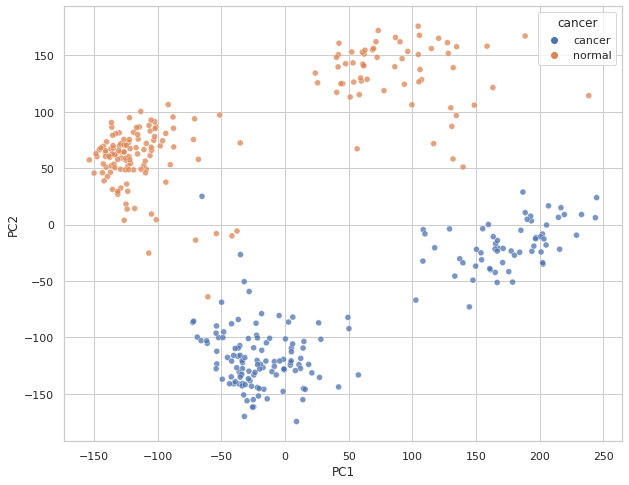

In [ ]:
df = pd.DataFrame({"PC1": X_pca[:,0], 
                   "PC2": X_pca[:,1],
                   "cancer": y})
plt.figure(figsize=(10, 8))
sns.scatterplot(x="PC1", y="PC2", hue="cancer", data=df, alpha=0.75);

**Какую долю дисперсии** объясняют найденные компоненты?

In [ ]:
for number, disp in enumerate(pca.explained_variance_ratio_):
    print(f'{disp} - {number+1}-я компонента')
print(f'Доля 2 компонент: {sum(pca.explained_variance_ratio_)}')

0.1807847899665864 - 1-я компонента
0.14134795450615095 - 2-я компонента
Доля 2 компонент: 0.3221327444727373


**Осуществите стандартизацию признаков** в выборке.

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Произведите **обучение модели** PCA и **визуализацию**. Оцените долю объясняемой дисперсии.

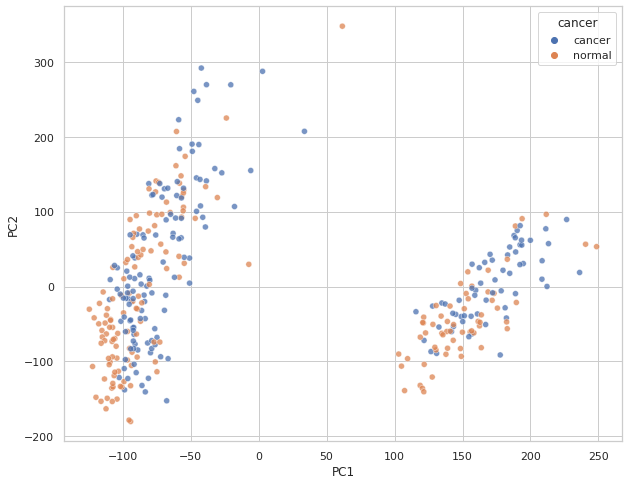

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df = pd.DataFrame({"PC1": X_pca[:,0], 
                   "PC2": X_pca[:,1],
                   "cancer": y})
plt.figure(figsize=(10, 8))
sns.scatterplot(x="PC1", y="PC2", hue="cancer", data=df, alpha=0.75);

**Какую долю дисперсии** объясняют найденные компоненты?

In [ ]:
for number, disp in enumerate(pca.explained_variance_ratio_):
    print(f'{disp} - {number+1}-я компонента')
print(f'Доля 2 компонент: {sum(pca.explained_variance_ratio_)}')

0.19235700495624855 - 1-я компонента
0.11975292600407035 - 2-я компонента
Доля 2 компонент: 0.3121099309603189


**Сделайте выводы**. Всегда ли стоит осуществлять нормализацию/стандартизацию транскриптомных данных?

**Вывод:** _После нормализации признаков доля объяснённой суммарной дисперсии практически не изменилась, при этом вместо разделения (как на графике РСА без нормализации) мы получили перемешанные данные больных и здоровых пациентов(это может быть связано с наличием батчей в данных), поэтому в этой ситуация стандартизация не улучшает (а может и ухудшить) визуализацию._

### Задача 2: Загрузка транскриптомных данных. Исправление batch-эффекта.

В этой задаче предлагается воспользоваться пакетом [pyComBat](https://github.com/epigenelabs/pyComBat) для коррекции batch-эффекта в транскриптомных данных.

**Установите пакет pyComBat в окружение**. Для этого воспользуйтесь инструкцией на главной странице [репозитория pyComBat](https://github.com/epigenelabs/pyComBat) на GitHub.

In [ ]:
!pip install combat
from combat.pycombat import pycombat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Разберитесь, как осуществляется коррекция batch-эффекта** в pyComBat и осуществите коррекцию.

In [ ]:
batch = meta_data['Dataset']
data_corrected = pycombat(data, batch)

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Adjusting the Data


**Сохраните полученный результат в файл** `gse53625_expression_corrected.csv`.

In [ ]:
with open('gse53625_expression_corrected.csv', 'w') as myFile:
    writer = csv.writer(myFile)
    writer.writerows(data_corrected)
     
print("Writing complete")

Writing complete


### Задача 3: Снижение размерности после коррекции batch-эффекта

В этой задаче предлагается сравнить результаты снижения размерности до и после коррекции batch-эффекта в транскриптомных данных.

**Загрузите датасет** `gse53625_expression_corrected.csv`, если вы не сделали предыдущее задание.

_Коррекция выполнена выше._

In [ ]:
#!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1P0OnSsTF9tn0yDq72k8ECVtgQL8pf_RP' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1P0OnSsTF9tn0yDq72k8ECVtgQL8pf_RP" -O gse53625_expression_corrected.csv && rm -rf /tmp/cookies.txt

In [ ]:
data_corrected

GSM1296956  GSM1296957  GSM1296958  GSM1296959  GSM1296960  \
gene                                                                 
1        12.674214   12.987667   12.711977   13.489024   12.901368   
2         3.143242    4.278811    4.308447    4.086773    4.258862   
24       14.048307   14.750568   14.467444   15.077056   14.606570   
25        3.483874    3.997953    4.006694    4.344528    4.096639   
26        5.264549    5.154276    5.476956    5.302151    5.665172   
...            ...         ...         ...         ...         ...   
179466    6.602825    5.572236    6.010736    6.394072    5.647020   
179793   11.780430   11.642013   12.374296   11.530342   11.935075   
179894    6.695574    4.975094    5.893230    6.439783    6.063440   
180296    9.055303    9.058335    9.257090    9.584316    8.833109   
180580    9.089258    8.062484   10.364733    9.452716   12.258325   

        GSM1296961  GSM1296962  GSM1296963  GSM1296964  GSM1296965  ...  \
gene                                                                ...   
1        13.526975   12.993459   13.450071   12.588025   13.606737  ...   
2         4.589622    3.832229    3.487092    4.937792    5.367026  ...   
24       15.100142   14.592636   14.766241   14.237996   14.443014  ...   
25        4.074519    3.647336    3.779404    4.517126    4.704675  ...   
26        5.981756    5.771721    5.288498    5.323961    5.655169  ...   
...            ...         ...         ...         ...         ...  ...   
179466    6.332921    5.875060    7.223804    6.039127    5.862985  ...   
179793   11.685578   11.270970   12.080558   12.030175   11.963093  ...   
179894    5.574649    5.867053    6.951638    5.656321    5.678790  ...   
180296    9.867453    7.981873    9.537683    8.335131    8.813889  ...   
180580    9.369199   11.172181    9.657664   10.061475    9.619461  ...   

        GSM1297304  GSM1297305  GSM1297306  GSM1297307  GSM1297308  \
gene                                                                 
1        14.727897   14.523008   13.501421   13.860442   14.767990   
2         3.204594    3.495522    4.375723    4.079782    3.411182   
24       14.809623   15.255460   15.134688   15.491234   14.849680   
25        3.521797    3.565114    3.808216    3.753003    3.512831   
26        6.888986    6.060270    5.646490    5.392184    5.927872   
...            ...         ...         ...         ...         ...   
179466    7.248772    7.392816    6.766080    6.937655    5.744857   
179793   11.893659   11.198377   12.315907   12.079125   11.843109   
179894    7.271014    7.058664    6.237756    5.823617    6.337388   
180296    9.335390   10.101204    8.409946    9.076598    8.804016   
180580   10.252437    9.456255    9.729644    8.720220    9.820697   

        GSM1297309  GSM1297310  GSM1297311  GSM1297312  GSM1297313  
gene                                                                
1        15.170535   14.915965   15.091634   15.120028   15.651637  
2         3.887538    3.442477    3.389745    3.094179    2.999229  
24       15.229039   14.919549   15.191480   14.920134   15.187458  
25        3.875662    3.473469    3.507107    3.350076    4.316806  
26        4.905115    5.825731    6.584014    5.985019    7.673099  
...            ...         ...         ...         ...         ...  
179466    5.787321    6.444544    6.386034    7.632751    9.121747  
179793   11.589751   12.705410   11.607227   12.345573   11.104259  
179894    5.935603    6.621769    6.354781    8.451982   10.633805  
180296    8.849207    9.415776    9.484836    9.692284   10.999624  
180580    8.354392   10.991637    9.895079   11.652171    8.538484  

[71584 rows x 358 columns]

Произведите **обучение модели** PCA и **визуализацию**. Оцените долю объясняемой дисперсии.

_Повторим шаги выше (см. задачу 1) для скорректированных данных. При этом попробуем увеличить количество компонент до 10 и посмотреть на долю объяснённой дисперсии:_

In [ ]:
X_corr = data_corrected.values.T
y = meta_data["Sample type"]

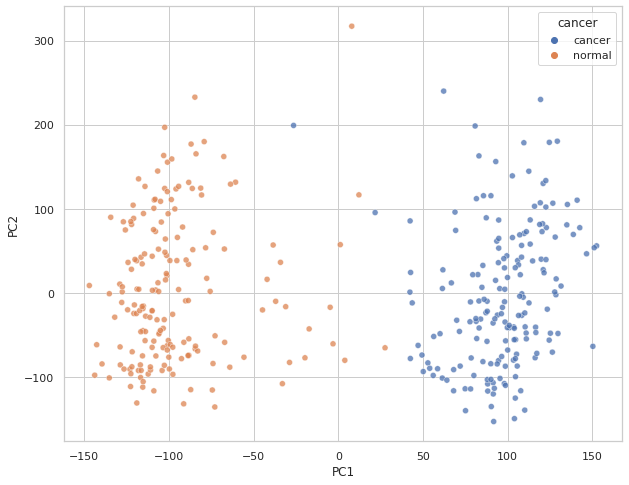

In [ ]:
pca_corr = PCA(n_components=10)
X_corr_pca = pca_corr.fit_transform(X_corr)

df = pd.DataFrame({"PC1": X_corr_pca[:,0], 
                   "PC2": X_corr_pca[:,1],
                   "cancer": y})
plt.figure(figsize=(10, 8))
sns.scatterplot(x="PC1", y="PC2", hue="cancer", data=df, alpha=0.75);

In [ ]:
for number, disp in enumerate(pca_corr.explained_variance_ratio_):
    print(f'{disp} - {number+1}-я компонента')
print(f'Доля 2 компонент: {sum(pca_corr.explained_variance_ratio_)}')

0.1804617874862227 - 1-я компонента
0.12866609365047846 - 2-я компонента
0.04967386376339832 - 3-я компонента
0.047451029523338656 - 4-я компонента
0.04101916037531125 - 5-я компонента
0.030162900513446462 - 6-я компонента
0.023489925639899115 - 7-я компонента
0.016978277220061143 - 8-я компонента
0.014394618317853403 - 9-я компонента
0.01333535558269607 - 10-я компонента
Доля 2 компонент: 0.5456330120727056


Произведите **стандартизацию данных** и повторите предыдущий пункт.

In [ ]:
scaler = StandardScaler()
X_corr_scaled = scaler.fit_transform(X_corr)

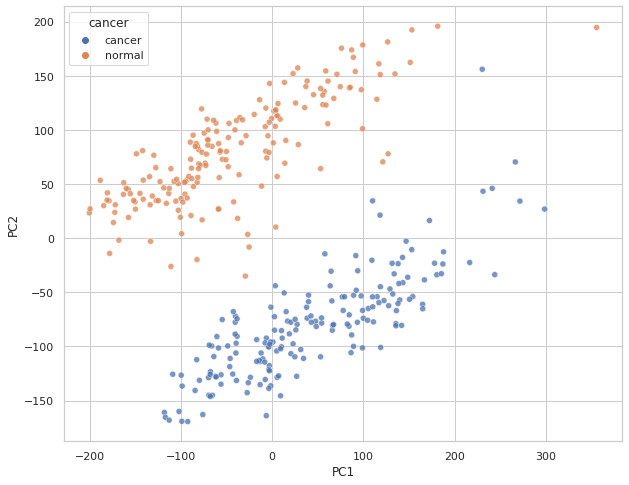

In [ ]:
pca_corr = PCA(n_components=10)
X_corr_pca = pca_corr.fit_transform(X_corr_scaled)

df = pd.DataFrame({"PC1": X_corr_pca[:,0], 
                   "PC2": X_corr_pca[:,1],
                   "cancer": y})
plt.figure(figsize=(10, 8))
sns.scatterplot(x="PC1", y="PC2", hue="cancer", data=df, alpha=0.75);

In [ ]:
for number, disp in enumerate(pca_corr.explained_variance_ratio_):
    print(f'{disp} - {number+1}-я компонента')
print(f'Доля 2 компонент: {sum(pca_corr.explained_variance_ratio_)}')

0.13878027645989638 - 1-я компонента
0.12216812442023825 - 2-я компонента
0.0622235331636279 - 3-я компонента
0.04649277789740657 - 4-я компонента
0.037400470199231935 - 5-я компонента
0.02679795736091492 - 6-я компонента
0.021709758089806925 - 7-я компонента
0.01905186673401158 - 8-я компонента
0.014657822477993958 - 9-я компонента
0.013513058353519982 - 10-я компонента
Доля 2 компонент: 0.5027956451566484


**Сделайте выводы**.

**Вывод:** _После использования peComBat (коррекции батчей) данные стали правильно разделяться (на 2 кластера - больные/здоровые), при этом можно отметить, что стандартизация визуально не очень изменила картину (однако заметно, что кластеры стали менее диффузными, что логично), доля объяснённой дисперсии (на 2ух компонентах) сильно не изменилась (дополнительно убедились в том, что при большем количестве компонент ситуация принципиально не меняется)._

### Задача 4: Классификация на основе данных сниженной размерности

В этой задаче предлагается сравнить качество двуклассовой классификации на исходных данных и на главных компонентах.

**Разбейте X и y на тренировочную и тестовую выборки**. Соотношение train/test поставьте равным 1:1.\
*Напоминание*: воспользуйтесь функцией `train_test_split`.

In [ ]:
y = y.replace('normal', 0)
y = y.replace('cancer', 1)
y

GEO accession
GSM1296956    1
GSM1296957    0
GSM1296958    1
GSM1296959    0
GSM1296960    1
             ..
GSM1297309    0
GSM1297310    1
GSM1297311    0
GSM1297312    1
GSM1297313    0
Name: Sample type, Length: 358, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_corr, y, test_size=0.5, random_state=1)

**Стандартизуйте данные и обучите на них модель логистической регрессии**.

In [ ]:
y_train

GEO accession
GSM1297160    1
GSM1297157    0
GSM1297297    0
GSM1297306    1
GSM1297243    0
             ..
GSM1297159    0
GSM1297211    0
GSM1297028    1
GSM1297191    0
GSM1296993    0
Name: Sample type, Length: 179, dtype: int64

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_train_sc, y_train)
y_pred = clf.predict(X_test_sc)

**Оцените качество модели**.

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        93
           1       0.99      0.99      0.99        86

    accuracy                           0.99       179
   macro avg       0.99      0.99      0.99       179
weighted avg       0.99      0.99      0.99       179



Подберите **оптимальное количество компонент для PCA** на `X_train`.

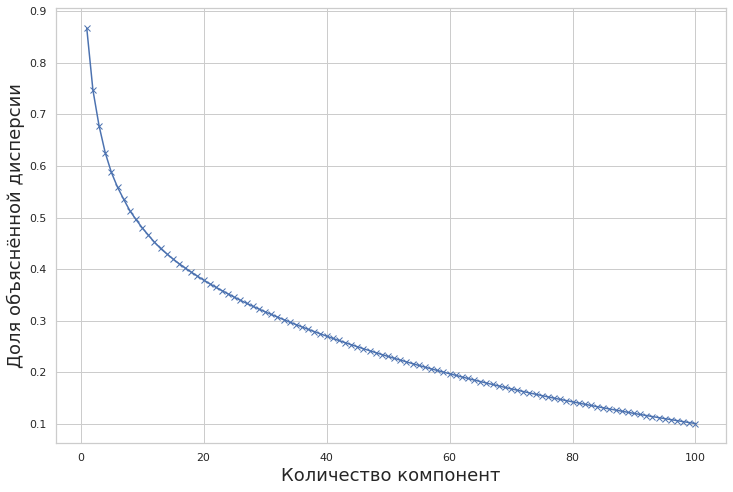

In [ ]:
n_comp = 100
pca_X = PCA(n_components=n_comp)
pcaY = pca_X.fit_transform(X_train_sc)

total_explained = 1 - np.cumsum(pca_X.explained_variance_ratio_[:n_comp])

plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, n_comp + 1), total_explained, "x-")
plt.xlabel('Количество компонент', fontsize=18)
plt.ylabel('Доля объяснённой дисперсии', fontsize=18)
plt.show()

In [ ]:
for number, disp in enumerate(pca_X.explained_variance_ratio_):
    print(f'{disp} - {number+1}-я компонента')
print(f'Доля 100 компонент: {sum(pca_X.explained_variance_ratio_)}')

0.13303514967930358 - 1-я компонента
0.1197279395436347 - 2-я компонента
0.06941999153738482 - 3-я компонента
0.05209692417654897 - 4-я компонента
0.03814095459687425 - 5-я компонента
0.02860682966149681 - 6-я компонента
0.023477659642886922 - 7-я компонента
0.022038838059692926 - 8-я компонента
0.017240513660901083 - 9-я компонента
0.01582497880997813 - 10-я компонента
0.014257984573287629 - 11-я компонента
0.013754562806328401 - 12-я компонента
0.012332679397456376 - 13-я компонента
0.010146912697136922 - 14-я компонента
0.009959397993184765 - 15-я компонента
0.009187274747517122 - 16-я компонента
0.008445978691185654 - 17-я компонента
0.008130357202585104 - 18-я компонента
0.007783909903591505 - 19-я компонента
0.007571991076322138 - 20-я компонента
0.007150029763479765 - 21-я компонента
0.006801995340771496 - 22-я компонента
0.006563022043996528 - 23-я компонента
0.006427455648436291 - 24-я компонента
0.006276166711217132 - 25-я компонента
0.005958219156981568 - 26-я компонента
0.0

In [ ]:
sum(pca_X.explained_variance_ratio_[:35])

0.7073523733339814

_Выберем n_comp = 33, поскольку хотим оставить компоненты, объясняющие по крайней мере 70% объяснённой дисперсии._

Повторите обучение и оценку качества **с добавлением метода снижения размерности** перед обучением классификатора.

In [ ]:
X_train_sc.shape

(179, 71584)

In [ ]:
pca_35 = PCA(n_components=35)
pca_35.fit(X_train_sc)
pcaY_35_train = pca_35.transform(X_train_sc)
pcaY_35_test = pca_35.transform(X_test_sc)

In [ ]:
clf = LogisticRegression(random_state=0).fit(pcaY_35_train, y_train)
y_pred_pca = clf.predict(pcaY_35_test)

**Оцените качество модели**.

In [ ]:
print(classification_report(y_test, y_pred_pca))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98        93
           1       0.98      0.99      0.98        86

    accuracy                           0.98       179
   macro avg       0.98      0.98      0.98       179
weighted avg       0.98      0.98      0.98       179



**Сделайте выводы**.

_В данной задаче оказалось, что основные параметры по классификации предсказываются очень хорошо как до, так и после использования использования метода главных компонент (возможно из-за большого количества последних); в случае высокой доли объяснённой дисперсии на первых нескольких главных компонентах (а на остальных незначительное количество) результат будет более заметно выражаться._

### Задача 5: Сравнение способов визуализации данных

В этой задаче предлагается сравнить различные способы визуализации данных друг с другом.

In [4]:
from sklearn.datasets import fetch_openml

In [5]:
mnist = fetch_openml('mnist_784')

In [6]:
X = mnist.data
y = mnist.target

**Визуализируйте эти данные с помощью PCA, t-SNE и UMAP**. Попробуйте несколько различных комбинаций параметров в каждом случае.

_Теперь выберем случайные 10000 объектов (потому что при 70000 алгоритмы работают крайне длительное время)._

In [7]:
X_y = pd.concat([X, y], axis=1).sample(10000)

In [11]:
X = X_y.iloc[:, :-1]
y = X_y['class']

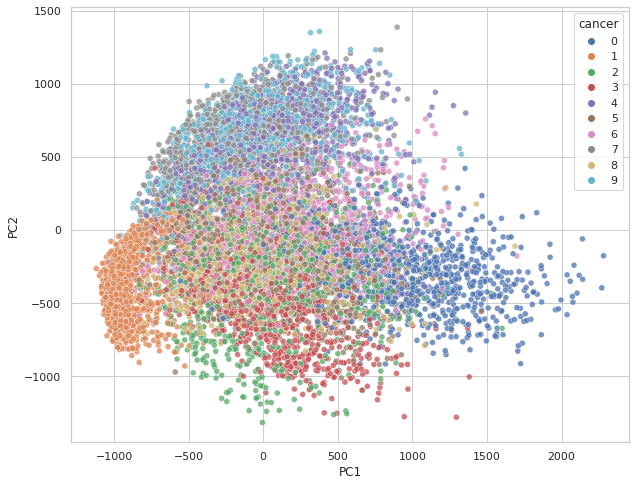

In [12]:
pca_X = PCA(n_components=50)
pcaY = pca_X.fit_transform(X)

df = pd.DataFrame({"PC1": pcaY[:,0],
                   "PC2": pcaY[:,1],
                   "cancer": y})
plt.figure(figsize=(10, 8))
sns.scatterplot(x="PC1", y="PC2", hue="cancer", data=df, alpha=0.75);

In [13]:
sum(pca_X.explained_variance_ratio_)

0.8255860775353165

_Видно, что первые 50 компонент содежат больше 80 процентов информации, поэтому можно будет использовать эти данные для визуализации в дальнейшем без серьёзной потери информации об объектах._

_Перейдём к t-SNE и UMAP. Будем подавать на вход UMAP и t-SNE первые 50 главных компонент, полученных выше. В случае t-SNE будем рассматривать различные варианты параметра Perplexity (n-iter не трогаем, поскольку даже при ограниченном наборе данных он работает крайне долго)._

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."
/usr/local/lib/python3.7/dist-packages/umap/spectral.py:261: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/usr/local/lib/python3.7/dist-packages/umap/spectral.py:261: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/usr/local/lib/python3.7/dist-packages/umap/s

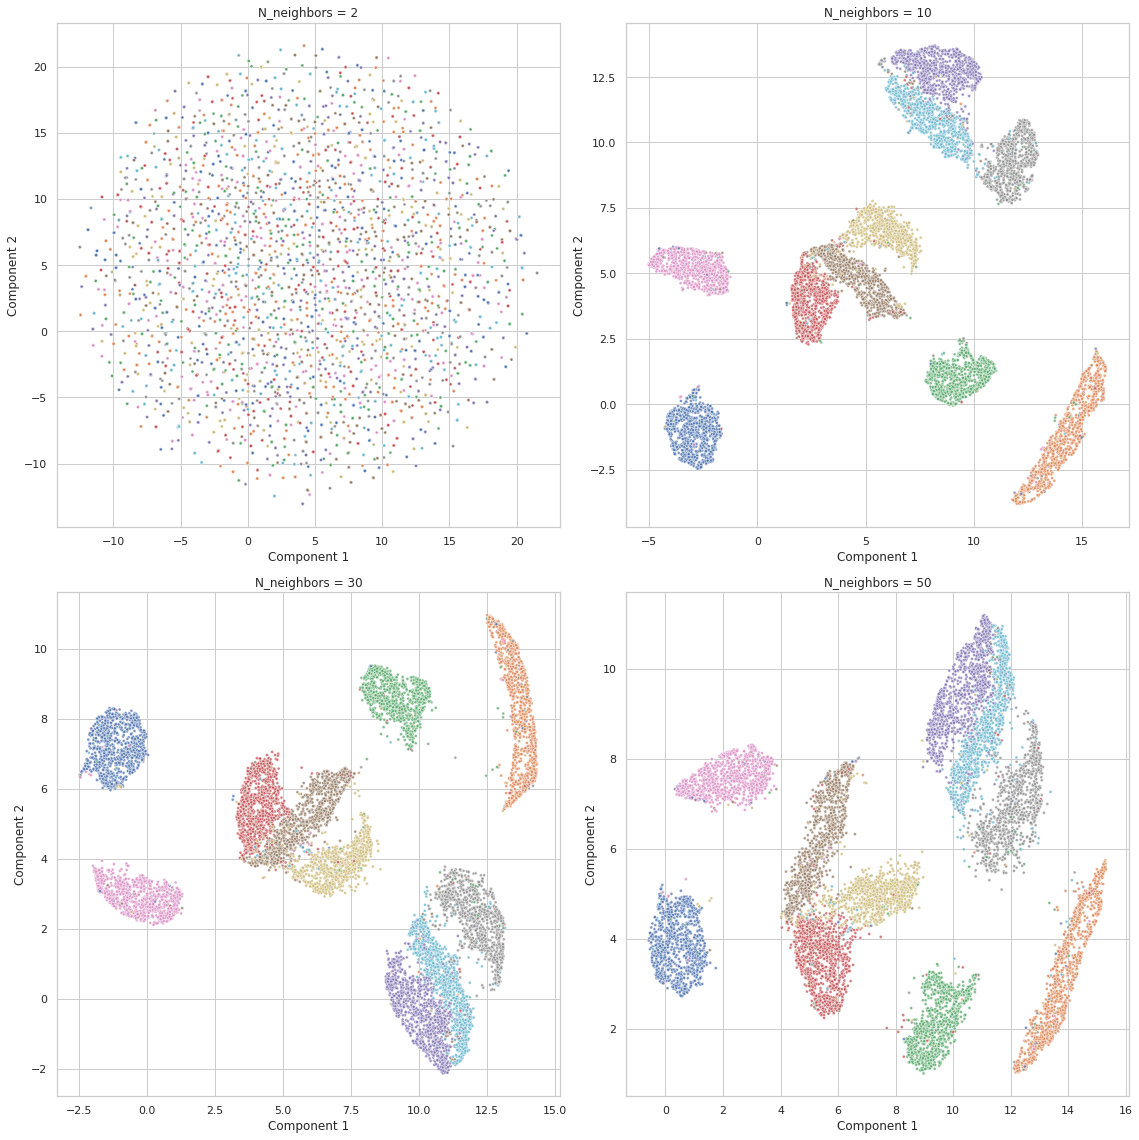

In [16]:
plt.figure(figsize=(16, 16))
for i, n_nei in enumerate([2, 10, 30, 50], 1):
    umap = UMAP(n_components=2, random_state=1, n_neighbors=n_nei)
    X_umap = umap.fit_transform(pcaY)
    df_s = pd.DataFrame({"Component 1": X_umap[:,0], "Component 2": X_umap[:,1], "cancer": y})
    
    plt.subplot(2, 2, i)
    sns.scatterplot(x="Component 1", y="Component 2", hue="cancer", data=df_s,
                    marker=".", alpha=0.75, legend=False)
    plt.title(f"N_neighbors = {n_nei}")

plt.tight_layout()

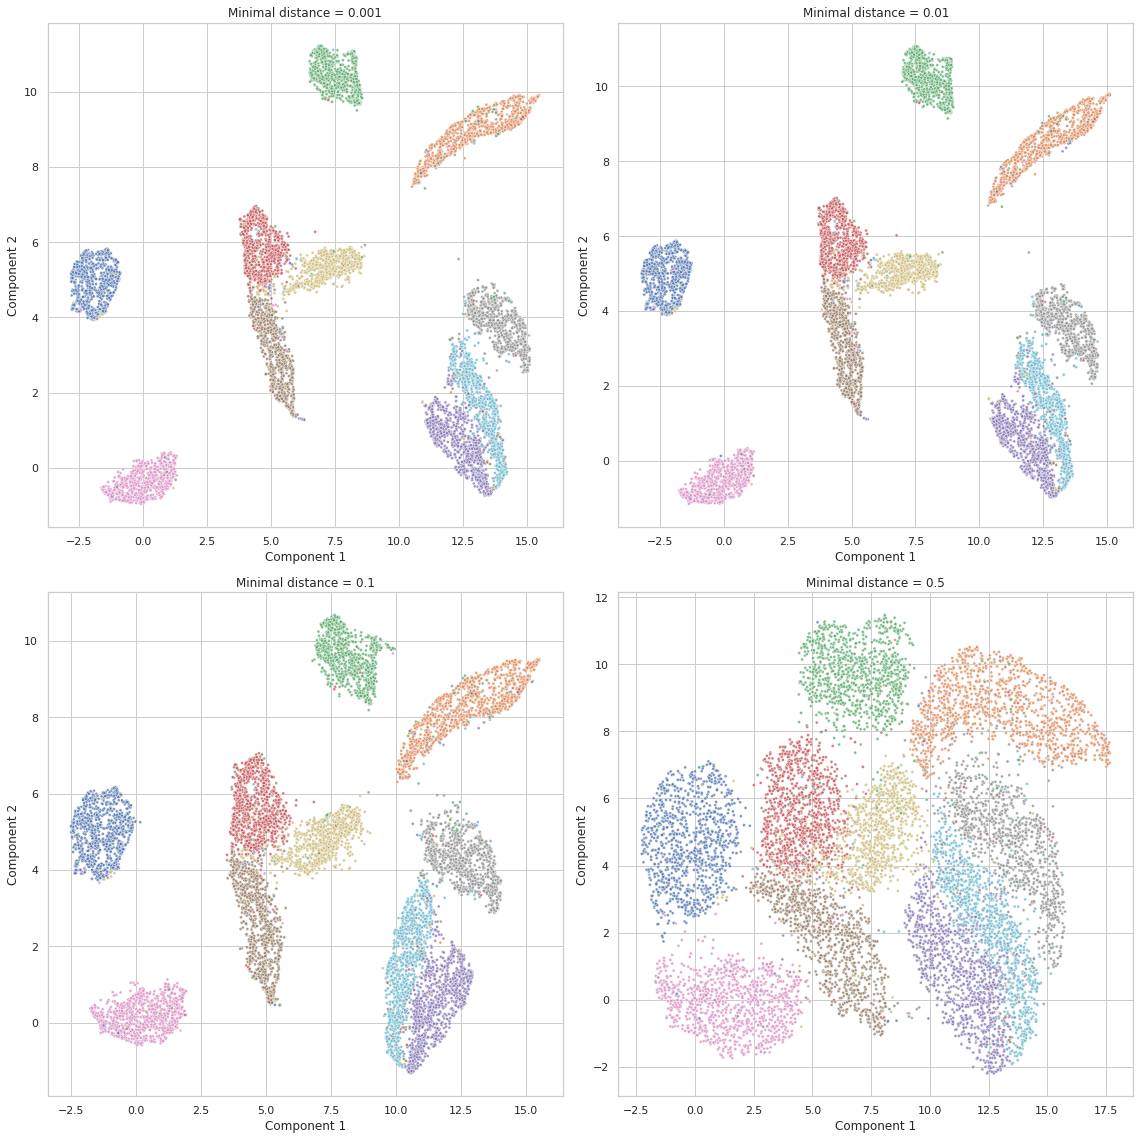

In [17]:
plt.figure(figsize=(16, 16))
for i, dist in enumerate([0.001, 0.01, 0.1, 0.5], 1):
    umap = UMAP(n_components=2, random_state=1, min_dist=dist)
    X_umap = umap.fit_transform(X)
    df_s = pd.DataFrame({"Component 1": X_umap[:,0], "Component 2": X_umap[:,1], "cancer": y})
    
    plt.subplot(2, 2, i)
    sns.scatterplot(x="Component 1", y="Component 2", hue="cancer", data=df_s,
                    marker=".", alpha=0.75, legend=False)
    plt.title(f"Minimal distance = {dist}")

plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default lea

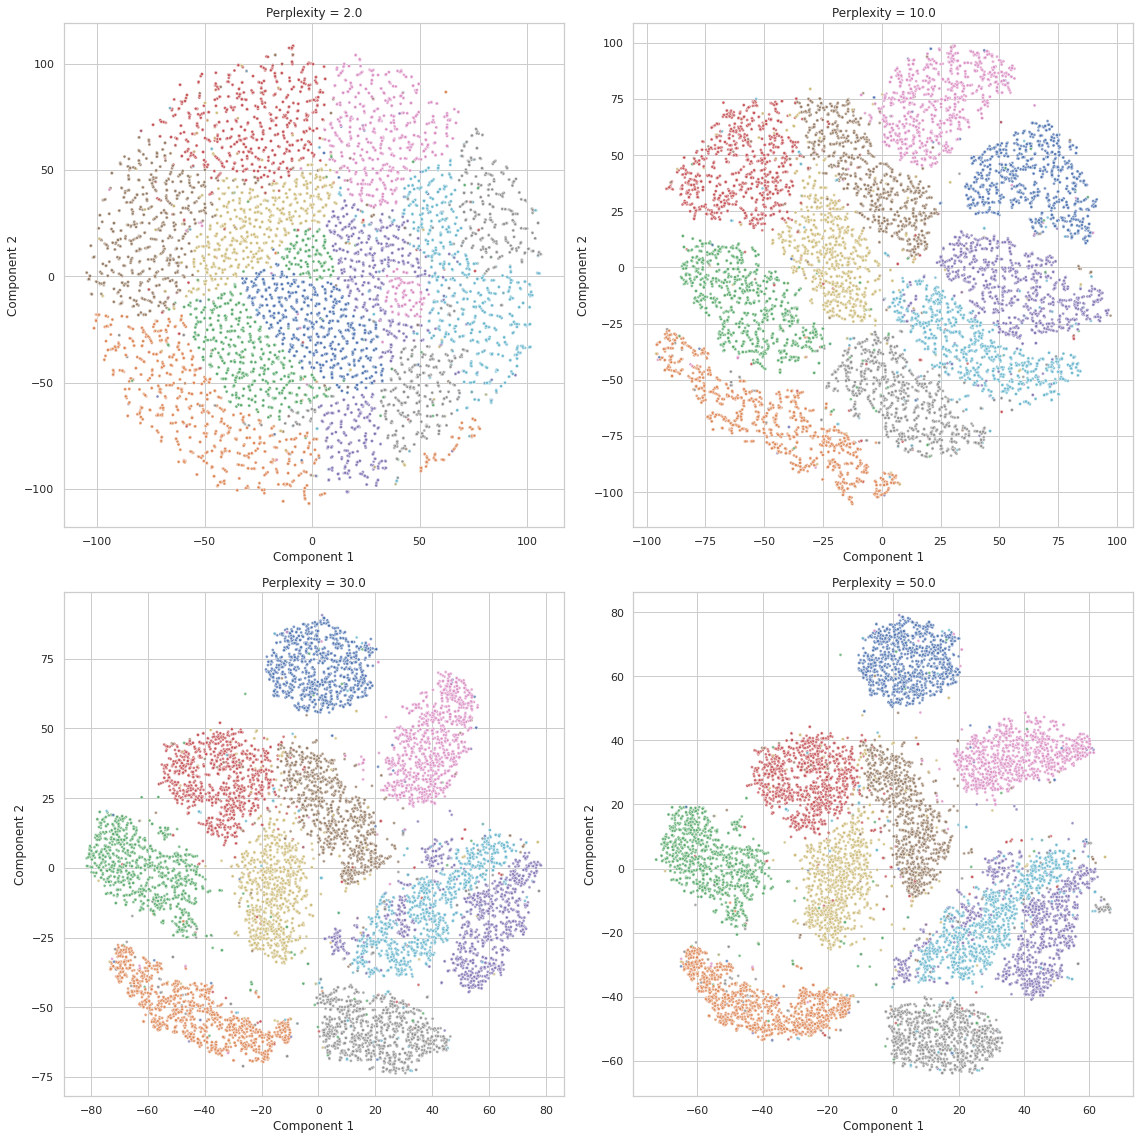

In [19]:
plt.figure(figsize=(16, 16))
for i, perp in enumerate([2.0, 10.0, 30.0, 50.0], 1):
    tsne = TSNE(n_components=2, random_state=1, perplexity=perp)
    X_tsne = tsne.fit_transform(pcaY)
    df_s = pd.DataFrame({"Component 1": X_tsne[:,0], "Component 2": X_tsne[:,1], "cancer": y})
    
    plt.subplot(2, 2, i)
    sns.scatterplot(x="Component 1", y="Component 2", hue="cancer", data=df_s,
                    marker=".", alpha=0.75, legend=False)
    plt.title(f"Perplexity = {perp}")

plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default lea

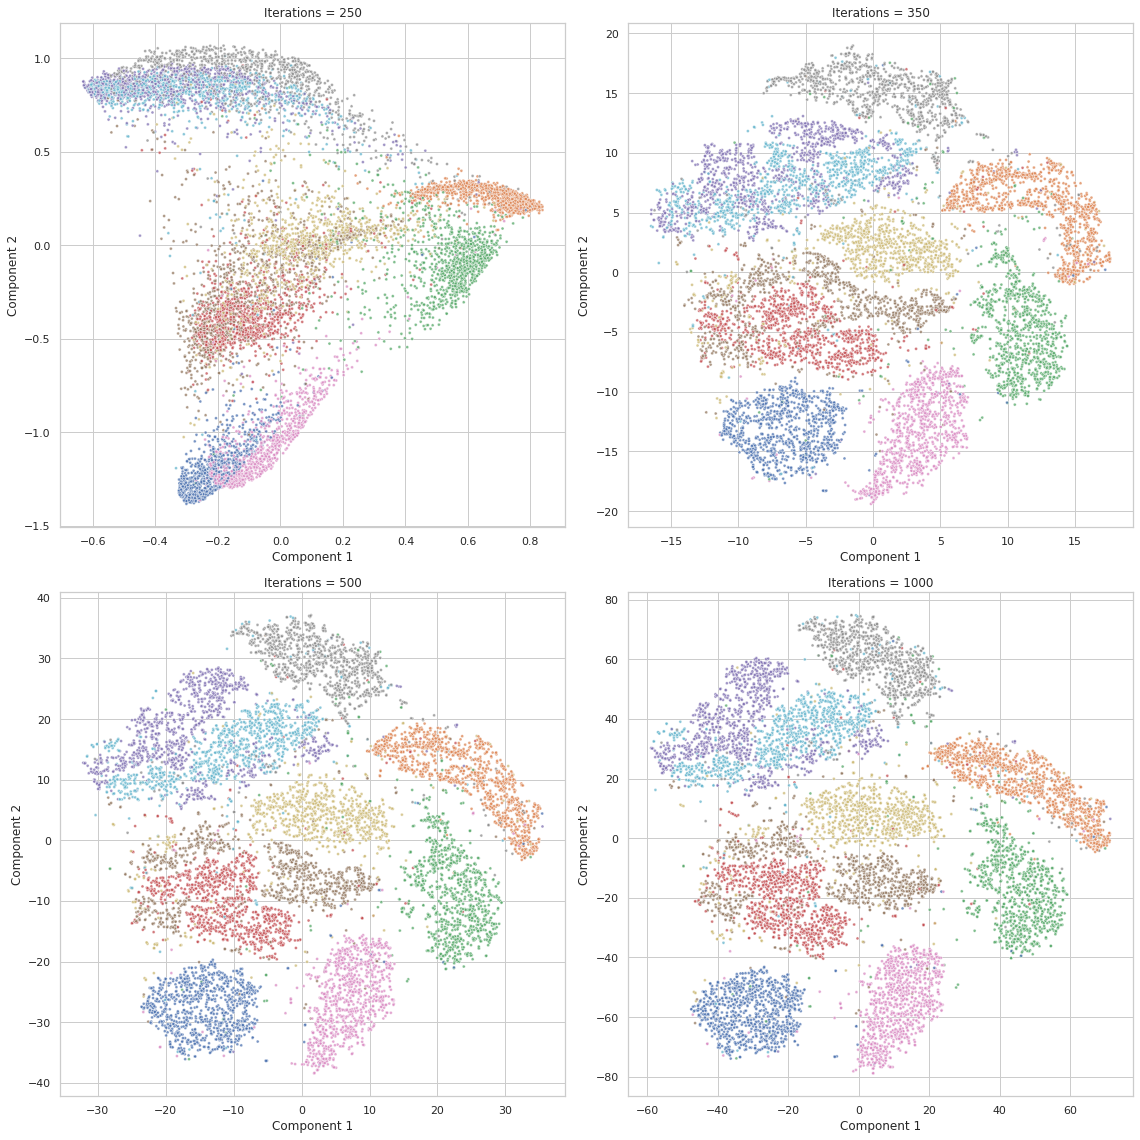

In [20]:
plt.figure(figsize=(16, 16))
for i, n_iter in enumerate([250, 350, 500, 1000], 1):
    tsne = TSNE(n_components=2, random_state=42, perplexity=50, n_iter=n_iter)
    X_tsne = tsne.fit_transform(X)
    df_s = pd.DataFrame({"Component 1": X_tsne[:,0], "Component 2": X_tsne[:,1], "cancer": y})
    
    plt.subplot(2, 2, i)
    sns.scatterplot(x="Component 1", y="Component 2", hue="cancer", data=df_s,
                    marker=".", alpha=0.75, legend=False)
    plt.title(f"Iterations = {n_iter}")
plt.tight_layout()

---

**Вывод:** _Посмотрим на различные визуализации:_  
_1) Визуализация после РСА не даёт какого-то осмысленного результата, информации в первых 2 компонентах недостаточно для того, чтобы можно было сделать какие-либо выводы._  
_2) Использование UMAP привело к хорошему результату - красивым и хорошо отделимым на графике кластерам. Отметим завимости, которые получилось рассмотреть._ _Оптимальное в нашем случае количество N-neib равно 10-30, если увеличивать - картинка смешивается, а при малом количестве (например, 2) кластеры даже не формируются. Для параметра min-dist оптимальный диапазон оказался достаточно широким - даже при 0,001 картинка получается наглядная. При увеличении этого параметра кластеры становятся более диффузными._  
_3) Для t-SNE оказалось, что оптимальный параметр perplexity - 30-50, при малых параметрах картина совпадает примерно с UMAP - кластеры не выделяются. Количество итераций должно быть хотя бы 1000 (стандартное значение), потому что при значениях 250 картина не успевает сформироваться (поскольку метод итеративный)._
